## Amazon Timestream Prediction of environment data
This is a notebook where we try to estimate the values of the sensors in out Timestream database with the Prophet-algorithm 

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
import timestreamquery as timestream
from IPython import display
import pandas as pd
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
# import sagemaker
import seaborn as sns
import numpy as np
import datetime as dt
from dotenv import load_dotenv
import os

load_dotenv()


True

In [2]:
#################################################
##### Timestream Configurations.  ###############
#################################################
ACCESS_KEY_ID_AWS = os.getenv("ACCESS_KEY_ID_AWS")
SECRET_ACCESS_KEY_AWS = os.getenv("SECRET_ACCESS_KEY_AWS")
assert ACCESS_KEY_ID_AWS
assert SECRET_ACCESS_KEY_AWS
ENDPOINT = "eu-west-1" # <--- specify the region service endpoint
PROFILE = "mose-timestream" # <--- specify the AWS credentials profile
DB_NAME = "SensorData" # <--- specify the database created in Amazon Timestream
TABLE_NAME = "particleTest" # <--- specify the table created in Amazon Timestream
TABLE_NAME_PREDICTION = "yrPrediction" # <--- specify the table created in Amazon Timestream


client = timestream.createQueryClient(ENDPOINT, aws_access_key_id=ACCESS_KEY_ID_AWS, aws_secret_access_key=SECRET_ACCESS_KEY_AWS)

## Logical view of data ##
```sql
DESCRIBE <db_name>.<table_name>
```

In [3]:
query_describe = """
DESCRIBE {}.{}
""".format(DB_NAME, TABLE_NAME)

describe_table = timestream.executeQueryAndReturnAsDataframe(client, query_describe, True)

display.display(describe_table)

QueryId: AEDQCANIFPTZD7EFIFP2W3IFJDWJW7SBTDVQCLGGQHBWK3YEE6PH4QOGQ4DMXPI
2022-11-08 12:23:12. QueryId: AEDQCANIFPTZD7EFIFP2W3IFJDWJW7SBTDVQCLGGQHBWK3YEE6PH4QOGQ4DMXPI Time: 4.051. First result: 4.051. Time to read results: 0.0.


,Column,Type,Timestream attribute type
0,tagId,varchar,DIMENSION
1,gateway_id,varchar,DIMENSION
2,measure_name,varchar,MEASURE_NAME
3,time,timestamp,TIMESTAMP
4,temperature,double,MULTI
5,humidity,double,MULTI
6,mc_2_5,bigint,MULTI
7,mc_10_0,bigint,MULTI
8,mc_4_0,bigint,MULTI
9,nc_10_0,bigint,MULTI


In [4]:
sensors = describe_table[describe_table["Timestream attribute type"] == "MULTI"]["Column"]
columns_to_extract = ", ".join([f"ROUND(AVG({sensor_name}), 2) as {sensor_name}_" for sensor_name in sensors])


In [5]:
query_get_all_data = f"""
SELECT BIN(time, 1h) as time_, {columns_to_extract}
FROM {DB_NAME}.{TABLE_NAME}
WHERE gateway_id='8'
GROUP BY BIN(time, 1h)
ORDER BY BIN(time, 1h)
"""

df = timestream.executeQueryAndReturnAsDataframe(client, query_get_all_data, True)
display.display(df)

QueryId: AEDQCANIFPTWRLOD3NQZVNF4Y2YJ7PA7JE3632UYVNPFTD5QGBG2YTGTCXBPGRA
2022-11-08 12:23:28. QueryId: AEDQCANIFPTWRLOD3NQZVNF4Y2YJ7PA7JE3632UYVNPFTD5QGBG2YTGTCXBPGRA Time: 10.578. First result: 10.578. Time to read results: 0.0.


,time_,temperature_,humidity_,mc_2_5_,mc_10_0_,mc_4_0_,nc_10_0_,mc_1_0_,nc_0_5_,nc_2_5_,nc_1_0_,nc_4_0_,typical_particle_size_
0,2022-09-16 14:00:00.000000000,11.90,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-16 15:00:00.000000000,11.77,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-16 16:00:00.000000000,11.88,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-16 17:00:00.000000000,11.83,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-16 18:00:00.000000000,11.74,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,2022-11-08 08:00:00.000000000,4.43,99.0,2.42,3.17,2.92,13.50,1.75,10.25,13.50,12.67,13.50,618.58
1267,2022-11-08 09:00:00.000000000,4.66,99.0,1.50,2.08,1.67,6.67,1.08,4.67,6.67,6.17,6.67,751.17
1268,2022-11-08 10:00:00.000000000,5.05,99.0,1.58,2.42,2.17,6.92,1.17,4.42,6.83,6.25,6.92,836.83
1269,2022-11-08 11:00:00.000000000,5.84,99.0,1.33,1.50,1.50,6.92,1.00,5.50,6.83,6.58,6.92,567.67


In [6]:
query_describe_prediction = """
DESCRIBE {}.{}
""".format(DB_NAME, TABLE_NAME_PREDICTION)

describe_table_prediction = timestream.executeQueryAndReturnAsDataframe(client, query_describe_prediction, True)

yr_prediction_columns = describe_table_prediction[describe_table_prediction["Timestream attribute type"] == "MULTI"]["Column"]
columns_to_extract_prediction = ", ".join([f'ROUND(AVG("{column}"), 2) as "{column}_"' for column in yr_prediction_columns])
query_get_all_data_prediction = f"""
SELECT BIN(time, 1h) as time_, {columns_to_extract_prediction}
FROM {DB_NAME}.{TABLE_NAME_PREDICTION}
GROUP BY BIN(time, 1h)
ORDER BY BIN(time, 1h)
"""

df_prediction = timestream.executeQueryAndReturnAsDataframe(client, query_get_all_data_prediction, True)

QueryId: AEDQCANIFPTX7DPO7T2BSHPGJ4FF4CKSPZZVJXBQTOOJ62LRNCCBJ2URZMXCUWI
2022-11-08 12:23:38. QueryId: AEDQCANIFPTX7DPO7T2BSHPGJ4FF4CKSPZZVJXBQTOOJ62LRNCCBJ2URZMXCUWI Time: 0.503. First result: 0.503. Time to read results: 0.0.
QueryId: AEDQCANIFPTRVNPAWF6MS2B4Z6PBYUDJMZYC5OJQ2FI4FT7CROHH7SKRDY76VEA
2022-11-08 12:24:02. QueryId: AEDQCANIFPTRVNPAWF6MS2B4Z6PBYUDJMZYC5OJQ2FI4FT7CROHH7SKRDY76VEA Time: 24.709. First result: 7.541. Time to read results: 17.167.


# Setting up Prophet with predictions from yr

In [7]:
df.index = pd.to_datetime(df.time_)
df.index = df.index.tz_localize(None)
series = fill_missing_values(
    TimeSeries.from_dataframe(df, value_cols=[sensor_name + "_" for sensor_name in sensors], fill_missing_dates=True))
df_prediction.index = pd.to_datetime(df_prediction.time_)
df_prediction.index = df_prediction.index.tz_localize(None)
df_prediction_renamed = df_prediction.rename(columns={
    '1h_air_temperature_': 'air_temperature_', 
    '1h_percipitation_': 'percipitation_',
    '1h_wind_speed_': 'wind_speed_',
    '1h_wind_direction_cos_': 'wind_direction_cos_',
    '1h_wind_direction_sin_': 'wind_direction_sin_'
})
series_prediction = fill_missing_values(
    TimeSeries.from_dataframe(df_prediction_renamed, value_cols=[
        'air_temperature_', 
        'percipitation_', 
        'wind_speed_',
        'wind_direction_cos_',
        'wind_direction_sin_'
        ], fill_missing_dates=True)
)




In [8]:
# use 1-24h predictions for the last value. Ideally we would have a sliding window for this for every point in time, but darts doesn't support that
# so for all the other points we will use the prediction 1h into the future. This will probably lead to a too narrow condfidence interval, but the difference is probably small
last_value = df_prediction.iloc[-24]
columns = list(set([col.split('h_')[1] for col in last_value.index if 'h_' in col ]))
predicted_forecast = pd.DataFrame([[last_value[f'{i}h_{column}'] for column in columns] for i in range(1,25)], columns=columns,
                index=[pd.to_datetime(last_value['time_']) + pd.DateOffset(hours=i) for i in range(24)])
predicted_forecast.index.name = 'time_'
series_prediction_test = fill_missing_values(
    TimeSeries.from_dataframe(predicted_forecast, value_cols=[
        'air_temperature_', 
        'percipitation_', 
        'wind_speed_',
        'wind_direction_cos_',
        'wind_direction_sin_'
        ], fill_missing_dates=True)
)
    
    

In [9]:
from darts.models.forecasting.prophet_model import Prophet
column_name_test = 'mc_2_5_'

In [10]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [14]:
series_train, series_test = series[:-24], series[int(-len(series)*0.2):]
prophet = Prophet(
    # seasonality_mode='multiplicative',
    # changepoint_prior_scale=0.01,
)
model_output = []
for sensor_name in sensors:
    sensor_name_ = sensor_name + "_"
    prophet.fit(
        series_train[sensor_name_], 
        future_covariates=series_prediction[:-24],
    )
    # back_test = eval_model(
    #     prophet, 
    #     series=series[sensor_name_], 
    #     # past_covariates=series_past, 
    #     future_covariates=series_prediction[:-24].concatenate(series_prediction_test)
    # )
    prediction_prophet = prophet.predict(n=24, 
                                    future_covariates=series_prediction[:-24].concatenate(series_prediction_test),
                                             num_samples=1000,
                                    )
    model_output.append((sensor_name, 
                         {
                             'percentile095': prediction_prophet.quantile(0.95),
                             'percentile050': prediction_prophet.quantile(0.50),
                             'percentile005': prediction_prophet.quantile(0.05)
                         }
                        ))
    

2022-11-08 13:27:33 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-11-08 13:27:34 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-11-08 13:27:35 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-11-08 13:27:36 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-11-08 13:27:38 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-11-08 13:27:39 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-11-08 13:27:40 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-11-08 13:27:41 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-11-08 13:27

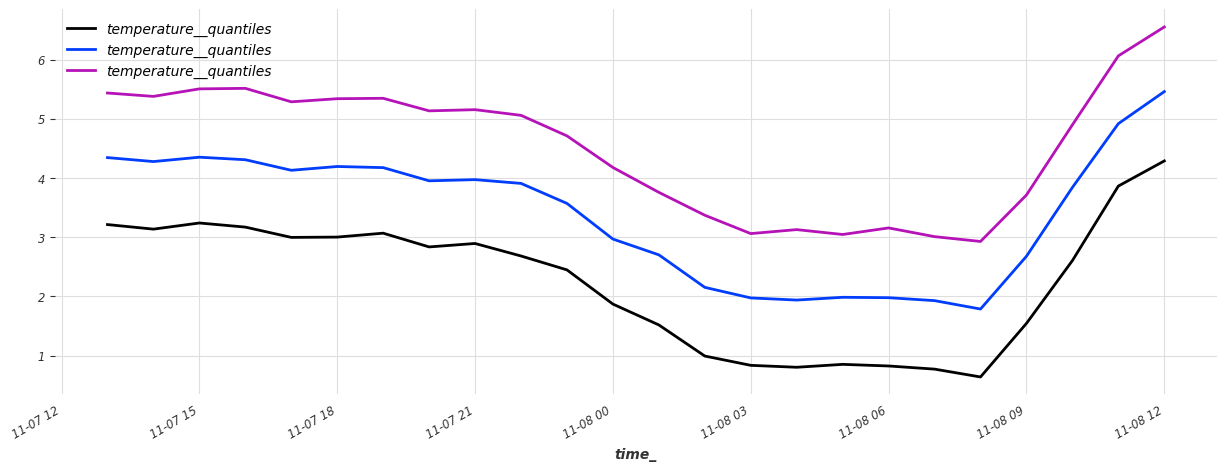

In [12]:
model_output[0][1]['percentile005'].plot()
model_output[0][1]['percentile050'].plot()
model_output[0][1]['percentile095'].plot()
series

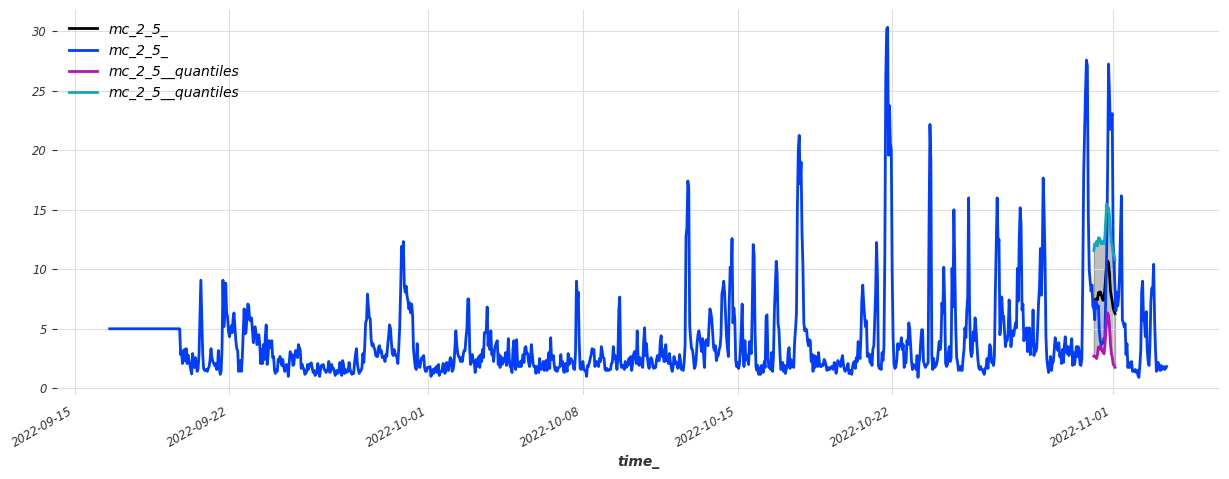

In [348]:
prediction_prophet = prophet.predict(n=24, 
                                    future_covariates=series_prediction[:-24].concatenate(series_prediction_test),
                                    num_samples=1000
                                    )
prediction_prophet.plot()
series[column_name_test].plot()
# series_prediction_test['typical'].plot()
prediction_prophet.quantile(0.05).plot()
prediction_prophet.quantile(0.95).plot()

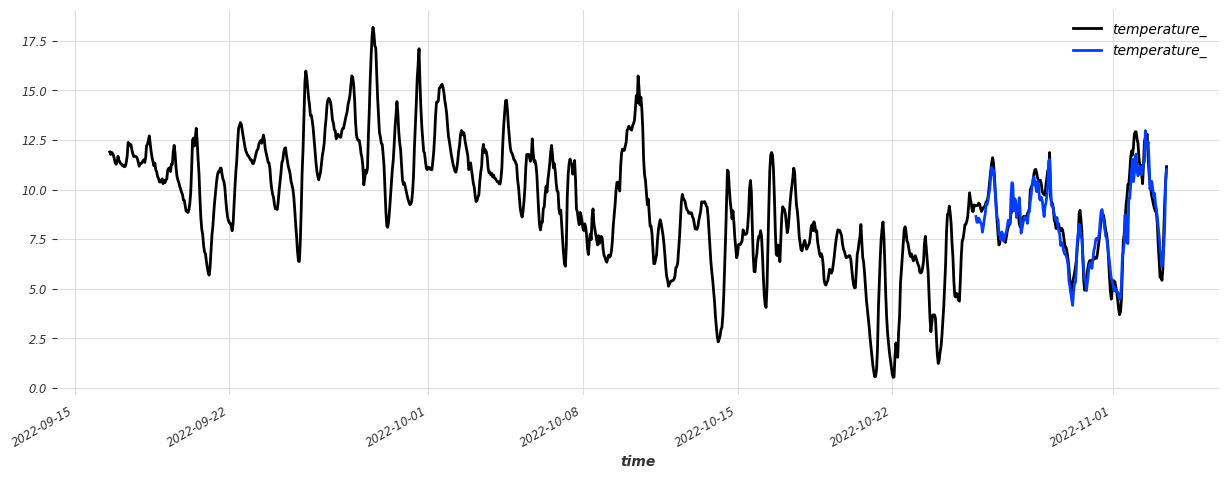

In [58]:
series['temperature_'].plot()
back_test['temperature_'].plot()